# Find duplicate questions on StackOverflow by their embeddings

In this assignment you will learn how to calculate a similarity for pieces of text. Using this approach you will know how to find duplicate questions from [StackOverflow](https://stackoverflow.com).

### Libraries

In this task you will you will need the following libraries:
- [StarSpace](https://github.com/facebookresearch/StarSpace) — a general-purpose model for efficient learning of entity embeddings from Facebook
- [Gensim](https://radimrehurek.com/gensim/) — a tool for solving various NLP-related tasks (topic modeling, text representation, ...)
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [Nltk](http://www.nltk.org) — a platform to work with human language data.

### Data

The following cell will download all data required for this assignment into the folder `week3/data`.

In [6]:
import sys
sys.path.append("..")
from common.download_utils import download_week3_resources

# download_week3_resources()

File data\train.tsv is already downloaded.
File data\validation.tsv is already downloaded.
File data\test.tsv is already downloaded.
File data\test_embeddings.tsv is already downloaded.


### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [2]:
from grader import Grader

In [3]:
grader = Grader()

## Word embedding

To solve the problem, you will use two different models of embeddings:

 - [Pre-trained word vectors](https://code.google.com/archive/p/word2vec/) from Google which were trained on a part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. `GoogleNews-vectors-negative300.bin.gz` will be downloaded in `download_week3_resources()`.
 - Representations using StarSpace on StackOverflow data sample. You will need to train them from scratch.

It's always easier to start with pre-trained embeddings. Unpack the pre-trained Goggle's vectors and upload them using the function [KeyedVectors.load_word2vec_format](https://radimrehurek.com/gensim/models/keyedvectors.html) from gensim library with the parameter *binary=True*. If the size of the embeddings is larger than the avaliable memory, you could load only a part of the embeddings by defining the parameter *limit* (recommended: 500000).

In [7]:
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors



In [8]:
fname = 'GoogleNews-vectors-negative300.bin.gz'
wv_embeddings  = KeyedVectors.load_word2vec_format(fname, binary=True)

#wv_embeddings = ######### YOUR CODE HERE #############

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'

### How to work with Google's word2vec embeddings?

Once you have loaded the representations, make sure you can access them. First, you can check if the loaded embeddings contain a word:
    
    'word' in wv_embeddings
    
Second, to get the corresponding embedding you can use the square brackets:

    wv_embeddings['word']
 
### Checking that the embeddings are correct 
 
To prevent any errors during the first stage, we can check that the loaded embeddings are correct. You can call the function *check_embeddings*, implemented below, which runs 3 tests:
1. Find the most similar word for provided "positive" and "negative" words.
2. Find which word from the given list doesn’t go with the others.
3. Find the most similar word for the provided one.

In the right case the function will return the string *These embeddings look good*. Othervise, you need to validate the previous steps.

In [9]:
def check_embeddings(embeddings):
    error_text = "Something wrong with your embeddings ('%s test isn't correct)."
    most_similar = embeddings.most_similar(positive=['woman', 'king'], negative=['man'])
    if len(most_similar) < 1 or most_similar[0][0] != 'queen':
        return error_text % "Most similar"

    doesnt_match = embeddings.doesnt_match(['breakfast', 'cereal', 'dinner', 'lunch'])
    if doesnt_match != 'cereal':
        return error_text % "Doesn't match"
    
    most_similar_to_given = embeddings.most_similar_to_given('music', ['water', 'sound', 'backpack', 'mouse'])
    if most_similar_to_given != 'sound':
        return error_text % "Most similar to given"
    
    return "These embeddings look good."

In [10]:
print(check_embeddings(wv_embeddings))

These embeddings look good.


C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## From word to text embeddings

**Task 1 (Question2Vec).** Usually, we have word-based embeddings, but for the task we need to create a representation for the whole question. It could be done in different ways. In our case we will use a **mean** of all word vectors in the question. Now you need to implement the function *question_to_vec*, which calculates the question representation described above. This function should work with the input text as is without any preprocessing.

Note that there could be words without the corresponding embeddings. In this case, you can just skip these words and don't take them into account during calculating the result. If the question doesn't contain any known word with embedding, the function should return a zero vector.

In [11]:
import numpy as np

In [12]:
import matplotlib.pyplot as plt
x=wv_embeddings['word']
im=np.expand_dims(x,axis=0);

fig, axes = plt.subplots(figsize=(100,20))
axes.imshow(im, interpolation='none')
plt.show()


<Figure size 10000x2000 with 1 Axes>

In [37]:
print(wv_embeddings['HELLO','WORLD'])


[[-5.41992188e-02 -5.05371094e-02 -3.88183594e-02 -3.90625000e-02
   1.23535156e-01 -2.73437500e-01 -3.84765625e-01 -1.03027344e-01
  -2.98828125e-01  4.88281250e-01  1.07421875e-01 -3.84765625e-01
  -1.02539062e-01  1.94335938e-01  4.27246094e-02  2.08007812e-01
   2.28515625e-01  3.19824219e-02 -1.32812500e-01 -3.51562500e-02
  -2.41699219e-02  2.27539062e-01  3.35937500e-01 -2.35351562e-01
  -2.83203125e-01 -1.14746094e-01  2.23388672e-02  5.58593750e-01
  -1.15356445e-02 -1.04003906e-01  1.32812500e-01  1.76757812e-01
  -2.57812500e-01 -1.66015625e-01 -1.05957031e-01 -5.34667969e-02
   1.63574219e-02  3.59375000e-01 -4.00390625e-02  6.49414062e-02
  -3.18359375e-01 -1.72851562e-01  1.43554688e-01  3.65234375e-01
   3.59375000e-01  8.00781250e-02 -3.22265625e-01  9.08203125e-02
  -2.41699219e-02  2.20703125e-01 -2.85156250e-01 -4.83398438e-02
   3.02734375e-01  5.15625000e-01  2.49023438e-01 -7.56835938e-02
  -3.55468750e-01 -5.71289062e-02 -7.75146484e-03 -1.30859375e-01
   3.30078

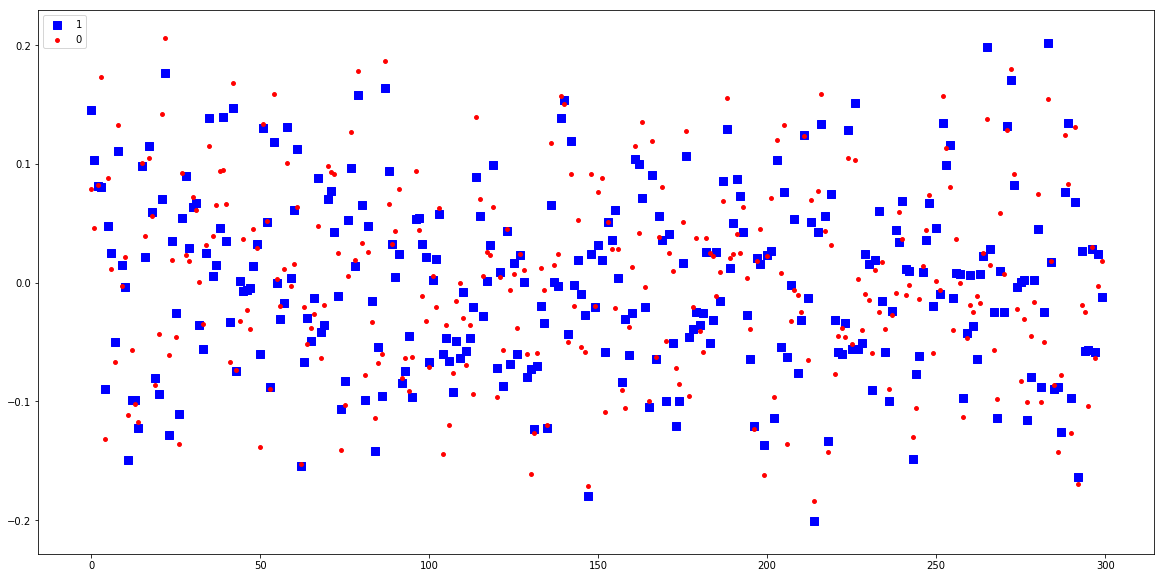

In [58]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

def question_to_vec(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    n=0;
    vec = np.zeros([dim])
    for w in question.split():
        if w in embeddings:
            vec+=embeddings[w]
            n+=1
    if n==0:
        return vec
    else:
        return vec/n
vec_1 = question_to_vec('How is it going man'  ,wv_embeddings)
vec_0 = question_to_vec('How is it going buddy',wv_embeddings)

x = np.arange(len(q_vec))

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x, q_1, s=50, c='b', marker="s", label='1')
ax1.scatter(x, q_0, s=15, c='r', marker="o", label='0')
plt.legend(loc='upper left');
plt.show()


To check the basic correctness of your implementation, run the function *question_to_vec_tests*.

In [59]:
def question_to_vec_tests():
    if (np.zeros(300) != question_to_vec('', wv_embeddings)).any():
        return "You need to return zero vector for empty question."
    if (np.zeros(300) != question_to_vec('thereisnosuchword', wv_embeddings)).any():
        return "You need to return zero vector for the question, which consists only unknown words."
    if (wv_embeddings['word'] != question_to_vec('word', wv_embeddings)).any():
        return "You need to check the corectness of your function."
    if ((wv_embeddings['I'] + wv_embeddings['am']) / 2 != question_to_vec('I am', wv_embeddings)).any():
        return "Your function should calculate a mean of word vectors."
    if (wv_embeddings['word'] != question_to_vec('thereisnosuchword word', wv_embeddings)).any():
        return "You should not consider words which embeddings are unknown."
    return "Basic tests are passed."

In [60]:
print(question_to_vec_tests())

Basic tests are passed.


You can submit embeddings for the questions from the file *test_embeddings.tsv* to earn the points. In this task you don't need to transform the text of a question somehow.

In [61]:
import nltk
nltk.download('stopwords')
from util import array_to_string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kovi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
question2vec_result = []
for question in open('data/test_embeddings.tsv'):
    question = question.strip()
    answer = question_to_vec(question, wv_embeddings)
    print(question)
    question2vec_result = np.append(question2vec_result, answer)

grader.submit_tag('Question2Vec', array_to_string(question2vec_result))

Play Framework 1.2.5 : OutOfMemoryError occured : Java heap space in play framework
Navigating between several views in iphone
A strange phenomenon of vector member in a class
Formula to auto change all calendar hours if I change 1 to keep the same total hours
Is there a way to redirect the browser from the bootstrap in Zend Framework?
How to read response from angular resource $save() and also keeping original data
Azure Resource Manager: unable to attach existing VHD when creating VM from powershell / azure preview portal
image is reverting to original when scrolling uitableview
View what methods/functions return a specific object in Visual Studio
JAXB Annotations - Mapping interfaces and @XmlElementWrapper
Installing an Aurelia web application on a web server other than ones for the turorial
Azure Blob Not Storing PDFs
Reserved Class Names in Groovy
Trouble filtering in Camel
Lookup Error ORA-00932: inconsistent datatypes: expected DATE got NUMBER
GWT tree with checkbox:How to get a

In [64]:
print(answer)

[ 6.63248698e-02 -1.25834147e-02  4.02018229e-02 -4.43929036e-02
 -1.25895182e-01  1.18611654e-01  7.18180339e-02  7.23470052e-02
  5.93566895e-02  8.13802083e-05 -1.64794922e-01 -7.28759766e-02
 -8.29874674e-02 -4.36655680e-02 -7.23876953e-02  1.46158854e-01
  8.70768229e-02  1.81182861e-01 -1.21663411e-01 -1.05621338e-01
 -3.37727865e-02  1.35884603e-01  6.65537516e-02  3.91438802e-02
 -4.16259766e-02 -1.43229167e-01 -1.13647461e-01  2.14192708e-01
 -9.93652344e-02 -1.28092448e-01 -1.05336507e-01 -1.34684245e-02
 -9.45841471e-02 -1.65506999e-01 -8.89485677e-02 -8.26822917e-02
 -8.03426107e-02  4.35791016e-02  1.15966797e-02 -3.13695272e-03
  9.83276367e-02 -2.89154053e-02  2.16837565e-01 -1.79443359e-02
 -8.40047201e-02 -1.43554688e-01 -9.56064860e-02 -1.08805339e-01
 -2.59195964e-02 -1.62556966e-02 -1.09558105e-01 -4.15039062e-02
  7.15204875e-02 -9.63541667e-02 -6.44152959e-02  1.60319010e-02
 -3.03141276e-03 -5.33548991e-02  6.42496745e-02  6.88069661e-02
  5.07609049e-02  7.04447

Now we have a method to create a representation of any sentence and we are ready for the first evaluation. So, let's check how well our solution (Google's vectors + *question_to_vec*) will work.

## Evaluation of text similarity

We can imagine that if we use good embeddings, the cosine similarity between the duplicate sentences should be less than for the random ones. Overall, for each pair of duplicate sentences we can generate *R* random negative examples and find out the position of the correct duplicate.  

For example, we have the question *"Exceptions What really happens"* and we are sure that another question *"How does the catch keyword determine the type of exception that was thrown"* is a duplicate. But our model doesn't know it and tries to find out the best option also among questions like *"How Can I Make These Links Rotate in PHP"*, *"NSLog array description not memory address"* and *"PECL_HTTP not recognised php ubuntu"*. The goal of the model is to rank all these 4 questions (1 *positive* and *R* = 3 *negative*) in the way that the correct one is in the first place.

However, it is unnatural to count on that the best candidate will be always in the first place. So let us consider the place of the best candidate in the sorted list of candidates and formulate a metric based on it. We can fix some *K* — a reasonalble number of top-ranked elements and *N* — a number of queries (size of the sample).

### Hits@K

The first simple metric will be a number of correct hits for some *K*:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [dup_i \in topK(q_i)]$$

where $q_i$ is the i-th query, $dup_i$ is its duplicate, $topK(q_i)$ is the top K elements of the ranked sentences provided by our model and the operation $[dup_i \in topK(q_i)]$ equals 1 if the condition is true and 0 otherwise (more details about this operation could be found [here](https://en.wikipedia.org/wiki/Iverson_bracket)).


### DCG@K
The second one is a simplified [DCG metric](https://en.wikipedia.org/wiki/Discounted_cumulative_gain):

$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le K] $$

where $rank_{dup_i}$ is a position of the duplicate in the sorted list of the nearest sentences for the query $q_i$. According to this metric, the model gets a higher reward for a higher position of the correct answer. If the answer does not appear in topK at all, the reward is zero. 

### Evaluation examples

Let's calculate the described metrics for the toy example introduced above. In this case $N$ = 1 and the correct candidate for $q_1$ is *"How does the catch keyword determine the type of exception that was thrown"*. Consider the following ranking of the candidates:
1. *"How Can I Make These Links Rotate in PHP"*
2. *"How does the catch keyword determine the type of exception that was thrown"*
3. *"NSLog array description not memory address"*
4. *"PECL_HTTP not recognised php ubuntu"*

Using the ranking above, calculate *Hits@K* metric for *K = 1, 2, 4*: 
 
- [K = 1] $\text{Hits@1} = \frac{1}{1}\sum_{i=1}^1 \, [dup_i \in top1(q_i)] = [dup_1 \in top1(q_1)] = 0$ because the correct answer doesn't appear in the *top1* list.
- [K = 2] $\text{Hits@2} = \frac{1}{1}\sum_{i=1}^1 \, [dup_i \in top2(q_i)] = [dup_1 \in top2(q_1)] = 1$ because $rank_{dup_1} = 2$.
- [K = 4] $\text{Hits@4} = \frac{1}{1}\sum_{i=1}^1 \, [dup_i \in top4(q_i)] = [dup_1 \in top4(q_1)] = 1$

Using the ranking above, calculate *DCG@K* metric for *K = 1, 2, 4*:

- [K = 1] $\text{DCG@1} = \frac{1}{1} \sum_{i=1}^1\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le 1] = \frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le 1] = 0$ because the correct answer doesn't appear in the top1 list.
- [K = 2] $\text{DCG@2} = \frac{1}{1} \sum_{i=1}^1\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le 2] = \frac{1}{\log_2{3}}$, because $rank_{dup_1} = 2$.
- [K = 4] $\text{DCG@4} = \frac{1}{1} \sum_{i=1}^1\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le 4] = \frac{1}{\log_2{3}}$.


**Tasks 2 and 3 (HitsCount and DCGScore).** Implement the functions *hits_count* and *dcg_score* as described above. Each function has two arguments: *dup_ranks* and *k*. *dup_ranks* is a list which contains *values of ranks* of duplicates. For example, *dup_ranks* is *[2]* for the example provided above.

In [81]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list of duplicates' ranks; one rank per question; 
                   length is a number of questions which we are looking for duplicates; 
                   rank is a number from 1 to len(candidates of the question); 
                   e.g. [2, 3] means that the first duplicate has the rank 2, the second one — 3.
        k: number of top-ranked elements (k in Hits@k metric)

        result: return Hits@k value for current ranking
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    return np.average(np.array(dup_ranks) <= np.array([k]))
    

Test your code on the tiny examples:

In [82]:
def test_hits():
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]
    
    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP", 
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    
    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1, 1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function."
    
    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown", 
               "Convert Google results object (pure js) to Python object"]
    
    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"], 
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."
        
    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP", 
                           "How does the catch keyword determine the type of exception that was thrown"], 
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."

    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP", 
                           "How does the catch keyword determine the type of exception that was thrown"], 
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(hits_count(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

In [83]:
print(test_hits())

Basic test are passed.


### DCG@K
The second one is a simplified [DCG metric](https://en.wikipedia.org/wiki/Discounted_cumulative_gain):

$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank_{dup_i})}\cdot[rank_{dup_i} \le K] $$

In [84]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list of duplicates' ranks; one rank per question; 
                   length is a number of questions which we are looking for duplicates; 
                   rank is a number from 1 to len(candidates of the question); 
                   e.g. [2, 3] means that the first duplicate has the rank 2, the second one — 3.
        k: number of top-ranked elements (k in DCG@k metric)

        result: return DCG@k value for current ranking
    """
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    dup_a = np.array(dup_ranks)    
    k_a   = np.array([k])
    d = np.average( (dup_a <=k_a )/(np.log2(1. + dup_a)) )
    return d

In [85]:
def test_dcg():
    # *Evaluation example*
    # answers — dup_i
    answers = ["How does the catch keyword determine the type of exception that was thrown"]
    
    # candidates_ranking — the ranked sentences provided by our model
    candidates_ranking = [["How Can I Make These Links Rotate in PHP", 
                           "How does the catch keyword determine the type of exception that was thrown",
                           "NSLog array description not memory address",
                           "PECL_HTTP not recognised php ubuntu"]]
    # dup_ranks — position of the dup_i in the list of ranks +1
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    
    # correct_answers — the expected values of the result for each k from 1 to 4
    correct_answers = [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function."
    
    # Other tests
    answers = ["How does the catch keyword determine the type of exception that was thrown", 
               "Convert Google results object (pure js) to Python object"]

    # The first test: both duplicates on the first position in ranked list
    candidates_ranking = [["How does the catch keyword determine the type of exception that was thrown",
                           "How Can I Make These Links Rotate in PHP"], 
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [1, 1]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both duplicates on the first position in ranked list)."
        
    # The second test: one candidate on the first position, another — on the second
    candidates_ranking = [["How Can I Make These Links Rotate in PHP", 
                           "How does the catch keyword determine the type of exception that was thrown"], 
                          ["Convert Google results object (pure js) to Python object",
                           "WPF- How to update the changes in list item of a list"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0.5, (1 + (1 / (np.log2(3)))) / 2]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: one candidate on the first position, another — on the second)."
        
    # The third test: both candidates on the second position
    candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                           "How does the catch keyword determine the type of exception that was thrown"], 
                          ["WPF- How to update the changes in list item of a list",
                           "Convert Google results object (pure js) to Python object"]]
    dup_ranks = [candidates_ranking[i].index(answers[i]) + 1 for i in range(len(answers))]
    correct_answers = [0, 1 / (np.log2(3))]
    for k, correct in enumerate(correct_answers, 1):
        if not np.isclose(dcg_score(dup_ranks, k), correct):
            return "Check the function (test: both candidates on the second position)."

    return "Basic test are passed."

In [86]:
print(test_dcg())

Basic test are passed.


Submit results of the functions *hits_count* and *dcg_score* for the following examples to earn the points.

In [87]:
test_examples = [
    [1],
    [1, 2],
    [2, 1],
    [1, 2, 3],
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [9, 5, 4, 2, 8, 10, 7, 6, 1, 3],
    [4, 3, 5, 1, 9, 10, 7, 8, 2, 6],
    [5, 1, 7, 6, 2, 3, 8, 9, 10, 4],
    [6, 3, 1, 4, 7, 2, 9, 8, 10, 5],
    [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
]

In [88]:
hits_results = []
for example in test_examples:
    for k in range(len(example)):
        hits_results.append(hits_count(example, k + 1))
grader.submit_tag('HitsCount', array_to_string(hits_results))

Current answer for task HitsCount is: 1.0
0.5
1.0
0.5
1.0
0.3333333333333333
0.6666666666666666
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1....


In [89]:
dcg_results = []
for example in test_examples:
    for k in range(len(example)):
        dcg_results.append(dcg_score(example, k + 1))
grader.submit_tag('DCGScore', array_to_string(dcg_results))

Current answer for task DCGScore is: 1.0
0.5
0.8154648767857288
0.5
0.8154648767857288
0.3333333333333333
0.5436432511904858
0.7103099178...


##  First solution: pre-trained embeddings

We will work with predefined train, validation and test corpora. All the files are tab-separated, but have a different format:
 - *train* corpus contains similar sentences at the same row.
 - *validation* corpus contains the following columns: *question*, *similar question*, *negative example 1*, *negative example 2*, ... 
 - *test* corpus contains the following columns: *question*, *example 1*, *example 2*, ...

Validation corpus will be used for the intermediate validation of models. The test data will be necessary for submitting the quality of your model in the system.

Now you should read *validation* corpus, located at `data/validation.tsv`. You will use it later to evaluate current solution.

In [90]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

In [91]:
validation = read_corpus("data/validation.tsv")######### YOUR CODE HERE #############

In [92]:
for K in [1,10,20,30]:
    print("#"*20)
    for i in validation[K][:5]+validation[K][-5:]:
        print(i)

####################
How to start PhoneStateListener programmatically?
PhoneStateListener and service
Java cast object[] to model
WCF and What does this mean?
How to uncheck checkbox using jQuery Uniform library
How can I render a GSP as a String?
publishing ASP.Net MVC 4 Project
how to hyperlink to a TFS item from visual studio
mutex attribute PTHREAD_PROCESS_SHARED inverts logic?
Unable to call SOAP Webservice using jQuery
####################
How to make the page not redirect in Rails
Rails 3: undefined method `remote_form_for'
C# run C++ OpenGL application in Panel
Excel VBA - Use an existing string in called sub
How do I change/customize the icon for the pegman on Google Maps?
Output spits two extra control characters, possibly a memory corruption bug?
How close to GPU theoretical memory bandwidth can you get?
Rally Authentication issue in Getting results
Vim movements: going to parent
datepicker how to add in cake php we need for steps
####################
Is it possible for a Ch

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

We will use cosine distance to rank candidate questions which you need to implement in the function *rank_candidates*. The function should return a sorted list of pairs *(initial position in candidates list, candidate)*. Index of some pair corresponds to its rank (the first is the best). For example, if the list of candidates was *[a, b, c]* and the most similar is *c*, then *a* and *b*, the function should return a list *[(2, c), (0, a), (1, b)]*.

Pay attention, if you use the function *cosine_similarity* from *sklearn.metrics.pairwise* to calculate similarity because it works in a different way: most similar objects has greatest similarity. It's preferable to use a vectorized version of *cosine_similarity* function. Try to compute similarity at once and not use list comprehension. It should speed up your computations significantly.

In [169]:
from numpy import dot
from numpy.linalg import norm
def f_cos_sim(a,b):
    cos_sim =  1-dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def rank_candidates(question, candidates, embeddings, dim=300):
    """
        question: a string
        candidates: a list of strings (candidates) which we want to rank
        embeddings: some embeddings
        dim: dimension of the current embeddings
        
        result: a list of pairs (initial position in the list, question)
    """
    
    question_vec = question_to_vec(question, embeddings, dim);
    candidates_vecs = [ question_to_vec(c, embeddings, dim) for c in candidates]
    similarity = [f_cos_sim(question_vec, c_vec) for c_vec in candidates_vecs]
    ranks = np.argsort(similarity)
    idx   = np.arange(len(candidates))
    cand_reorder = [ (idx[r],candidates[r]) for r in ranks]
    return cand_reorder
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
print(test_rank_candidates())


--- Expected---
[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]
True
--- Expected---
[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]
True
Basic tests are passed.


Test your code on the tiny examples:

In [170]:
def test_rank_candidates(dim=300):
    questions = ['converting string to list', 'Sending array via Ajax fails']
    candidates = [['Convert Google results object (pure js) to Python object', 
                   'C# create cookie from string and send it',
                   'How to use jQuery AJAX for an outside domain?'], 
                  ['Getting all list items of an unordered list in PHP', 
                   'WPF- How to update the changes in list item of a list', 
                   'select2 not displaying search results']]
    results = [[(1, 'C# create cookie from string and send it'), 
                (0, 'Convert Google results object (pure js) to Python object'), 
                (2, 'How to use jQuery AJAX for an outside domain?')],
               [(0, 'Getting all list items of an unordered list in PHP'), 
                (2, 'select2 not displaying search results'), 
                (1, 'WPF- How to update the changes in list item of a list')]]
    for question, q_candidates, result in zip(questions, candidates, results):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, dim)
        if not np.all(ranks == result):
            return "Check the function."
    return "Basic tests are passed."

In [168]:
print(test_rank_candidates())

--- Expected---
[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]
True
--- Expected---
[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]
True
Basic tests are passed.


Now we can test the quality of the current approach. Run the next two cells to get the results. Pay attention that calculation of similarity between vectors takes time and this calculation is computed approximately in 10 minutes.

In [171]:
wv_ranking = []
for line in validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [172]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

DCG@   1: 0.217 | Hits@   1: 0.217
DCG@   5: 0.271 | Hits@   5: 0.319
DCG@  10: 0.288 | Hits@  10: 0.370
DCG@ 100: 0.326 | Hits@ 100: 0.560
DCG@ 500: 0.358 | Hits@ 500: 0.818
DCG@1000: 0.378 | Hits@1000: 1.000


If you did all the steps correctly, you should be frustrated by the received results. Let's try to understand why the quality is so low. First of all, when you work with some data it is necessary to have an idea how the data looks like. Print several questions from the data:

In [173]:
for line in validation[:3]:
    q, *examples = line
    print(q, *examples[:3])

How to print a binary heap tree without recursion? How do you best convert a recursive function to an iterative one? How can i use ng-model with directive in angular js flash: drawing and erasing
How to start PhoneStateListener programmatically? PhoneStateListener and service Java cast object[] to model WCF and What does this mean?
jQuery: Show a div2 when mousenter over div1 is over when hover on div1 depenting on if it is on div2 or not it should act differently How to run selenium in google app engine/cloud? Python Comparing two lists of strings for similarities


As you can see, we deal with the raw data. It means that we have many punctuation marks, special characters and unlowercased letters. In our case, it could lead to the situation where we can't find some embeddings, e.g. for the word "grid?". 

To solve this problem you should use the functions *text_prepare* from the previous assignments to prepare the data.

In [174]:
from util import text_prepare

In [175]:
import pickle
pickle.dump( wv_ranking, open( "wv_ranking.pkl", "wb" ) )

Now transform all the questions from the validation set:

In [199]:
prepared_validation = [[text_prepare(q) for q in l] for l in validation]


In [201]:
pickle.dump( prepared_validation, open( "prepared_validation.pkl", "wb" ) )

Let's evaluate the approach again after the preparation:

In [202]:
wv_prepared_ranking = []
for line in prepared_validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings)
    wv_prepared_ranking.append([r[0] for r in ranks].index(0) + 1)

C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [203]:
pickle.dump( wv_prepared_ranking, open( "wv_prepared_ranking.pkl", "wb" ) )

In [204]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_prepared_ranking, k), 
                                              k, hits_count(wv_prepared_ranking, k)))

DCG@   1: 0.320 | Hits@   1: 0.320
DCG@   5: 0.387 | Hits@   5: 0.448
DCG@  10: 0.404 | Hits@  10: 0.500
DCG@ 100: 0.438 | Hits@ 100: 0.669
DCG@ 500: 0.460 | Hits@ 500: 0.844
DCG@1000: 0.477 | Hits@1000: 1.000


Now, prepare also train and test data, because you will need it in the future:

In [205]:
def prepare_file(in_, out_):
    out = open(out_, 'w')
    for line in open(in_, encoding='utf8'):
        line = line.strip().split('\t')
        new_line = [text_prepare(q) for q in line]
        print(*new_line, sep='\t', file=out)
    out.close()

In [209]:
######################################
######### YOUR CODE HERE #############
######################################
for s in ['train','test']:
    file_in  = "data/%s.tsv"%s
    file_out ="data/%s_prep.tsv"%s
    prepare_file(file_in, file_out)
    print([file_in, file_out])

['data/train.tsv', 'data/train_prep.tsv']
['data/test.tsv', 'data/test_prep.tsv']


**Task 4 (W2VTokenizedRanks).** For each question from prepared *test.tsv* submit the ranks of the candidates to earn the points. The calculations should take about 3-5 minutes. Pay attention that the function *rank_candidates* returns a ranking, while in this case you should find a position in this ranking. Ranks should start with 1.

In [212]:
from util import matrix_to_string


Current answer for task W2VTokenizedRanks is: 1
1
1
1
1
1
1
1
1	2
2	1
1
1
1	2
1
1
1
1
1
1
1	2
1
2	1
1
2	1
1
1
1
1
1
1
2	1
1
1
1
2	1
1
1
1
1
1
1
1
...


In [215]:
w2v_ranks_results = []
prepared_test_data = 'data/test_prep.tsv'######### YOUR CODE HERE #############
for line in open(prepared_test_data):
    q, *ex = line.strip().split('\t')
    ranks = rank_candidates(q, ex, wv_embeddings, 300)
    ranked_candidates = [r[0] for r in ranks]
    w2v_ranks_results.append([ranked_candidates.index(i) + 1 for i in range(len(ranked_candidates))])
    
grader.submit_tag('W2VTokenizedRanks', matrix_to_string(w2v_ranks_results))

C:\Users\kovi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


Current answer for task W2VTokenizedRanks is: 95	94	7	9	64	37	32	93	24	100	98	17	60	6	97	49	70	38	42	96	30	21	2	65	67	45	27	26	57	62	11	88	56	66	7...


## Advanced solution: StarSpace embeddings

Now you are ready to train your own word embeddings! In particular, you need to train embeddings specially for our task of duplicates detection. Unfortunately, StarSpace cannot be run on Windows and we recommend to use provided
[docker container](https://github.com/hse-aml/natural-language-processing/blob/master/Docker-tutorial.md) or other alternatives. Don't delete results of this task because you will need it in the final project.

### How it works and what's the main difference with word2vec?
The main point in this section is that StarSpace can be trained specifically for some tasks. In contrast to word2vec model, which tries to train similar embeddings for words in similar contexts, StarSpace uses embeddings for the whole sentence (just as a sum of embeddings of words and phrases). Despite the fact that in both cases we get word embeddings as a result of the training, StarSpace embeddings are trained using some supervised data, e.g. a set of similar sentence pairs, and thus they can better suit the task.

In our case, StarSpace should use two types of sentence pairs for training: "positive" and "negative". "Positive" examples are extracted from the train sample (duplicates, high similarity) and the "negative" examples are generated randomly (low similarity assumed). 

### How to choose the best params for the model?
Normally, you would start with some default choice and then run extensive experiments to compare different strategies. However, we have some recommendations ready for you to save your time:
- Be careful with choosing the suitable training mode. In this task we want to explore texts similarity which corresponds to *trainMode = 3*.
- Use adagrad optimization (parameter *adagrad = true*).
- Set the length of phrase equal to 1 (parameter *ngrams*), because we need embeddings only for words.
- Don't use a large number of *epochs* (we think that 5 should be enough).
- Try dimension *dim* equal to 100.
- To compare embeddings usually *cosine* *similarity* is used.
- Set *minCount* greater than 1 (for example, 2) if you don't want to get embeddings for extremely rare words.
- Parameter *verbose = true* could show you the progress of the training process.
- Set parameter *fileFormat* equals *labelDoc*.
- Parameter *negSearchLimit* is responsible for a number of negative examples which is used during the training. We think that 10 will be enought for this task.
- To increase a speed of training we recommend to set *learning rate* to 0.05.

Train StarSpace embeddings for unigrams on the train dataset. You don't need to change the format of the input data. Just don't forget to use prepared version of the training data. 

If you follow the instruction, the training process will take about 1 hour. The size of the embeddings' dictionary should be approximately 100 000 (number of lines in the result file). If you got significantly more than this number, try to check all the instructions above.

In [ ]:
######### TRAINING HAPPENING HERE #############

And now we can compare the new embeddings with the previous ones. You can find trained word vectors in the file *[model_file_name].tsv*. Upload the embeddings from StarSpace into a dict. 

In [ ]:
starspace_embeddings = ######### YOUR CODE HERE #############

In [ ]:
ss_prepared_ranking = []
for line in prepared_validation:
    q, *ex = line
    ranks = rank_candidates(q, ex, starspace_embeddings, 100)
    ss_prepared_ranking.append([r[0] for r in ranks].index(0) + 1)

In [ ]:
for k in [1, 5, 10, 100, 500, 1000]:
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(ss_prepared_ranking, k), 
                                               k, hits_count(ss_prepared_ranking, k)))

Due to training for the particular task with the supervised data, you should expect to obtain a higher quality than for the previous approach. In additiion, despite the fact that StarSpace's trained vectors have a smaller dimension than word2vec's, it provides better results in this task.

**Task 5 (StarSpaceRanks).** For each question from prepared *test.tsv* submit the ranks of the candidates for trained representation.

In [ ]:
starspace_ranks_results = []
prepared_test_data = ######### YOUR CODE HERE #############
for line in open(prepared_test_data):
    q, *ex = line.strip().split('\t')
    ranks = rank_candidates(q, ex, starspace_embeddings, 100)
    ranked_candidates = [r[0] for r in ranks]
    starspace_ranks_results.append([ranked_candidates.index(i) + 1 for i in range(len(ranked_candidates))])
    
grader.submit_tag('StarSpaceRanks', matrix_to_string(starspace_ranks_results))

Please, **don't remove** the file with these embeddings because you will need them in the final project.

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [217]:
STUDENT_EMAIL = 'const.vin@gmail.com' # EMAIL 
STUDENT_TOKEN ='SqfSZ7bKRpo7j1jH' # TOKEN 
grader.status()

You want to submit these parts:
Task Question2Vec: 0.019293891059027776
-0.028727213541666668
0.046056111653645836
0.08525933159722222
0.02430555555555...
Task HitsCount: 1.0
0.5
1.0
0.5
1.0
0.3333333333333333
0.6666666666666666
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1....
Task DCGScore: 1.0
0.5
0.8154648767857288
0.5
0.8154648767857288
0.3333333333333333
0.5436432511904858
0.7103099178...
Task W2VTokenizedRanks: 95	94	7	9	64	37	32	93	24	100	98	17	60	6	97	49	70	38	42	96	30	21	2	65	67	45	27	26	57	62	11	88	56	66	7...
Task StarSpaceRanks: ----------...


If you want to submit these answers, run cell below

In [216]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
